In [1]:
import numpy as np
import matplotlib.pyplot as plt

Řešte Poissonovu rovnici $\Delta \phi = \beta$ s nulovou Dirichletovou okrajovou podmínkou metodou konečných diferencí. Tedy, řešte soustavu  $KU=b$, kde $K$ je matice druhých diferencí. Použijte Jacobiho relaxační metodu.

In [2]:
# x = <0, 1>
L = 1.0 # 1D domain length
N = 99  # number of unknowns - at inner grid points

h = L/(N+1) # step size

In [3]:
def poisson_solve_Jacobi(N, h, b, bc=[0, 0], epsilon = 1e-8, U0 = None):
    """Solve Poisson equation KU=b by Jacobi method
    b is the right hand side (N elements), resulting U also includes the
    boundary points (N+2) elements. Convergence is achieved when the norm of residuum is below epsilon.
    Returns U and the number of iterations"""
    
    if U0 is None: U = np.zeros(N+2)
    else: U = U0

    U[[0,-1]] = bc
    niter = 0
    
    while True:
        res = 0.5*(U[:-2] + U[2:] - h**2*b) - U[1:-1]
        U[1:-1] += res
        niter += 1
        if sum(res**2) < epsilon**2: break
            
    return U, niter

In [4]:
# test problem:
b = np.ones(N)

# known solution
def sol(x): return 0.5*(x-.5)**2-.125

In [5]:
U, niter = poisson_solve_Jacobi(N, h, b)

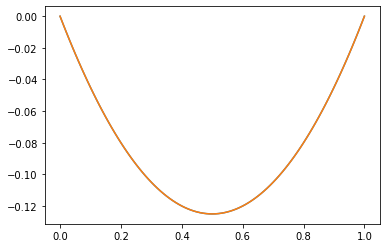

In [6]:
x = np.linspace(0, 1, N+2)
plt.plot(x, U)
plt.plot(x, sol(x))

<ipython-input-7-00fa720d960e>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, (U - sol(x))/sol(x))


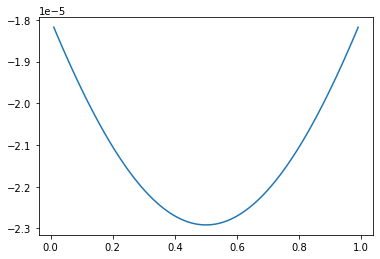

In [7]:
plt.plot(x, (U - sol(x))/sol(x))

Vypočtěte sílu působící na částici s nábojem $q=1$ mezi deskami kondenzátoru v poloze $x=L/3$. Předpokládejte $\epsilon_0 = 1$.

In [8]:
def sample_NGP(x, rho, h, q, N):
    xi = np.round(x/h).astype(int)
    if xi >=0 and xi < N+2: 
        rho[xi] += q

In [9]:
def minusgrad(U, h):
    E = np.zeros_like(U)
    # return -grad(U) on inner points using second order centered differences
    # boundary values can be obtained using 
    E[0] = -(-3*U[0] + 4*U[1] - U[2])/(2*h)
    E[-1] = -(3*U[-1] - 4*U[-2] + U[-3])/(2*h)
    E[1:-1] = -(U[2:] - U[:-2])/(2*h)
    return E

In [10]:
def interpolate_NGP(x, E, h, N):
    xi = np.round(x/h).astype(int)
    if xi >=0 and xi < N+2: 
        return E[xi]

In [11]:
rho = np.zeros(N+2)
x = L/3
eps0 = 1.
q = 1.

In [12]:
sample_NGP(x, rho, h, q, N)

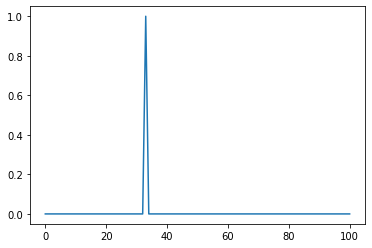

In [13]:
plt.plot(rho)

In [14]:
U, niter = poisson_solve_Jacobi(N, h, -rho[1:-1]/eps0)

In [15]:
E = minusgrad(U, h)

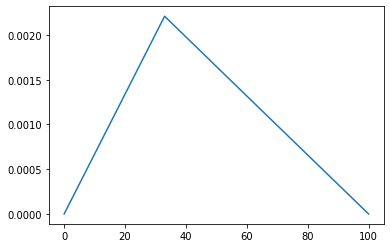

In [16]:
plt.plot(U)

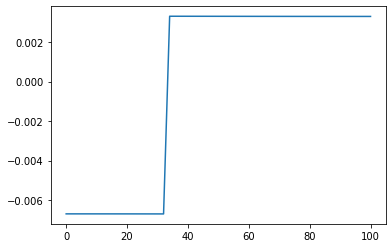

In [17]:
plt.plot(E)

In [18]:
interpolate_NGP(x, E, h, N)

-0.001696760563608176

Vypočtěte závislost síly na poloze

In [19]:
L = 1.0 # 1D domain length
N = 9  # number of unknowns - at inner grid points

h = L/(N+1) # step size

Fxs = []
rho = np.zeros(N+2)
U = np.zeros(N+2)

xs = np.linspace(0, L)
for x in xs:
    rho[:] = 0
    sample_NGP(x, rho, h, q, N)
    U, niter = poisson_solve_Jacobi(N, h, -rho[1:-1]/eps0, U0 = U)
    E = minusgrad(U, h)
    Fx = q*interpolate_NGP(x, E, h, N)
    Fxs.append(Fx)

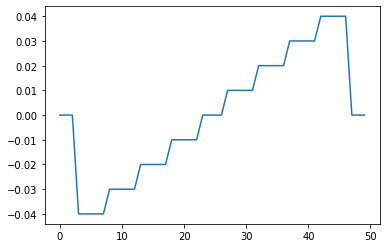

In [20]:
plt.plot(Fxs)

In [21]:
def interpolate_CIC(x, E, h, N):
    xf = x/h
    xi = np.ceil(xf).astype(int)
    w = xi - xf
    if w==0 and xi >= 0 and xi < N+2:
        return E[xi]
    if xi > 0 and xi < N+2: 
        return w*E[xi-1] + (1-w)*E[xi]

In [22]:
def sample_CIC(x, rho, h, q, N):
    xf = x/h
    xi = np.ceil(xf).astype(int)
    w = xi - xf
    if w==0 and xi >= 0 and xi < N+2:
        rho[xi] += q
    if xi > 0 and xi < N+2: 
        rho[xi-1] += w*q
        rho[xi] += (1-w)*q

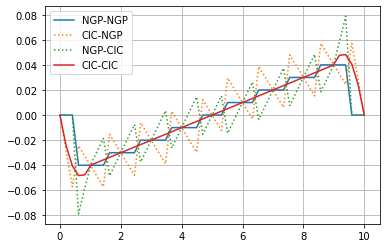

In [23]:
L = 1.0 # 1D domain length
N = 9  # number of unknowns - at inner grid points

h = L/(N+1) # step size
rho = np.zeros(N+2)
U = np.zeros(N+2)

for sampler, interpolator, kws in [
        (sample_NGP, interpolate_NGP, dict(label="NGP-NGP")),
        (sample_CIC, interpolate_NGP, dict(label="CIC-NGP", ls=":")),
        (sample_NGP, interpolate_CIC, dict(label="NGP-CIC", ls=":")),
        (sample_CIC, interpolate_CIC, dict(label="CIC-CIC")),
        ]:
    Fxs = []

    for x in xs:
        rho[:] = 0
        sampler(x, rho, h, q, N)
        U, niter = poisson_solve_Jacobi(N, h, -rho[1:-1]/eps0, U0 = U)
        E = minusgrad(U, h)
        Fx = q*interpolator(x, E, h, N)
        Fxs.append(Fx)
    plt.plot(xs/h, Fxs, **kws)
plt.legend()
plt.grid()